# Uncertainty Evaluation (resnet34 from scratch on Office-31)

In [1]:
# for Google Colab
%pip install torchinfo wandb

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import torch
import torchvision
import wandb
from tqdm.autonotebook import trange

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 85.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.7/206.7 kB 28.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.2 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=0f9283d41e257d081e010f0539858ae1f5339f5de8d1ad539c5d87de16b793f6
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


<ipython-input-1-5a27692a5959>:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange


In [2]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [3]:
run = wandb.init(
    project="i2r-active-da-02_uncertainty_office-31",
    job_type="train",
    config={
        # parameters roughly similar to LIRR
        "optim": {
            "algorithm": "AdamW",
            "lr": 1e-3,
            "weight_decay": 5e-4,
        },
        "params": {
            "batch_size": 64,
            "num_epochs": 30,
            "T": 0.1,
        },
        "cuda_device": 0,
        "architecture": "resnet34-cosc",
        "train_dataset": "office-31_amazon",
        "test_dataset": "office-31_dslr",
        "seed": 123456,
    },
)
config = run.config

"""
sweep_configuration = {
    'method': 'grid',
    'name': 'sweep',
    'metric': {
        'goal': 'maximize', 
        'name': 'test.top1',
        },
    'parameters': {
        'T': {'min': 0.05, 'max': 1, 'q': 0.05 },
    }
}
sweep_id = wandb.sweep(sweep=sweep_configuration, project="i2r-active-da-02_uncertainty_office-31")
"""

run.tags += (config.architecture,)
if config.train_dataset == config.test_dataset:
    run.tags += (config.train_dataset,)
else:
    run.tags += (f"{config.train_dataset}-to-{config.test_dataset}",)

wandb: Currently logged in as: wei2912. Use `wandb login --relogin` to force relogin


## Office-31 Dataset

On first project run, please download the dataset at https://github.com/jindongwang/transferlearning/blob/master/data/dataset.md#office-31 and extract to `data/office-31`.

In [4]:
try:
    artifact = run.use_artifact("office-31-dataset:latest")
    artifact.download("data/office-31/")
except wandb.CommError as e:
    print("Uploading data to WandB.")
    artifact = wandb.Artifact("office-31-dataset", type="dataset")
    artifact.add_dir("data/office-31/")
    run.log_artifact(artifact)

wandb: Downloading large artifact office-31-dataset:latest, 78.76MB. 4110 files... 
wandb:   4110 of 4110 files downloaded.  
Done. 0:1:41.2


In [5]:
from torch.utils.data import Subset
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Resize, ToTensor

# from utils import get_balanced_ids

match config.train_dataset:
    case "office-31_amazon":
        train_data = ImageFolder(
            root="data/office-31/amazon/images",
            transform=Compose([Resize(224), ToTensor()]),
        )

train_loader = torch.utils.data.DataLoader(
    train_data,
    # Subset(train_data, list(get_balanced_ids(train_data, seed=config.seed))),
    batch_size=config.params["batch_size"],
    shuffle=True,
    pin_memory=True,
)

match config.test_dataset:
    case "office-31_dslr":
        test_data = ImageFolder(
            root="data/office-31/dslr/images",
            transform=Compose([Resize(224), ToTensor()]),
        )
    case "office-31_webcam":
        test_data = ImageFolder(
            root="data/office-31/webcam/images",
            transform=Compose([Resize(224), ToTensor()]),
        )

test_loader = torch.utils.data.DataLoader(
    test_data,
    # Subset(test_data, list(get_balanced_ids(test_data, seed=config.seed+1))),
    batch_size=config.params["batch_size"],
    pin_memory=True,
)

assert sorted(train_data.class_to_idx.items()) == sorted(test_data.class_to_idx.items())

torch.Size([64, 3, 224, 224])
Label: 12


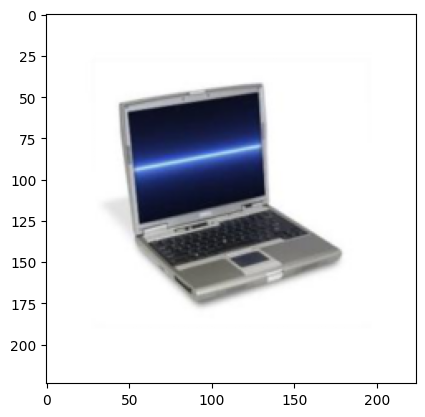

In [6]:
train_inputs, train_targets = next(iter(train_loader))
plt.imshow(torch.einsum("cwh->whc", train_inputs[0]))

print(train_inputs.size())
print(f"Label: {train_targets[0]}")

torch.Size([64, 3, 224, 224])
Label: 0


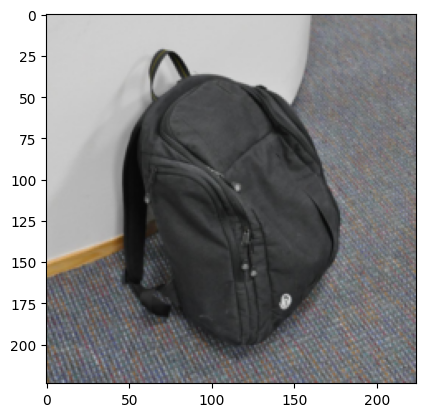

In [7]:
test_inputs, test_targets = next(iter(test_loader))
plt.imshow(torch.einsum("cwh->whc", test_inputs[0]))
assert train_inputs.size() == test_inputs.size()

print(test_inputs.size())
print(f"Label: {test_targets[0]}")

In [8]:
from collections import Counter

train_targets = Counter()
for _, targets in list(train_loader):
    train_targets.update(targets.tolist())

test_targets = Counter()
for _, targets in list(test_loader):
    test_targets.update(targets.tolist())

print(f"Train: {sorted(train_targets.items())}")
print(f"Test: {sorted(test_targets.items())}")

Train: [(0, 92), (1, 82), (2, 72), (3, 82), (4, 36), (5, 94), (6, 91), (7, 97), (8, 97), (9, 81), (10, 99), (11, 100), (12, 100), (13, 98), (14, 100), (15, 99), (16, 100), (17, 94), (18, 96), (19, 95), (20, 93), (21, 100), (22, 98), (23, 98), (24, 90), (25, 75), (26, 100), (27, 99), (28, 99), (29, 96), (30, 64)]
Test: [(0, 12), (1, 21), (2, 24), (3, 12), (4, 16), (5, 12), (6, 13), (7, 14), (8, 15), (9, 15), (10, 13), (11, 10), (12, 24), (13, 16), (14, 31), (15, 22), (16, 12), (17, 8), (18, 10), (19, 10), (20, 13), (21, 15), (22, 23), (23, 18), (24, 10), (25, 7), (26, 18), (27, 26), (28, 21), (29, 22), (30, 15)]


## Training Setup

In [9]:
torch.cuda.set_device(config.cuda_device)
device = torch.device(
    f"cuda:{config.cuda_device}" if torch.cuda.is_available() else "cpu"
)

In [10]:
from torch.nn import CosineSimilarity, Linear, Module
from torchinfo import summary
from torchvision.models import resnet18, resnet34


class CosC(Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.fc = Linear(**kwargs, bias=False)
        self.cos = CosineSimilarity(dim=1)

    def forward(self, x):
        x = x.reshape(x.size() + (1,))
        w_t = self.fc.weight.T.reshape((1,) + self.fc.weight.T.size())
        return self.cos(x, w_t) / config.params["T"]


match config.architecture:
    case "resnet18":
        model = resnet18(weights=None).to(device)
        model.fc = Linear(
            in_features=model.fc.in_features,
            out_features=len(train_data.classes),
            bias=True,
        )
    case "resnet18-cosc":
        model = resnet18(weights=None).to(device)
        model.fc = CosC(
            in_features=model.fc.in_features, out_features=len(train_data.classes)
        )
    case "resnet34":
        model = resnet34(weights=None).to(device)
        model.fc = Linear(
            in_features=model.fc.in_features,
            out_features=len(train_data.classes),
            bias=True,
        )
    case "resnet34-cosc":
        model = resnet34(weights=None).to(device)
        model.fc = CosC(
            in_features=model.fc.in_features, out_features=len(train_data.classes)
        )

summary(model, input_size=(config.params["batch_size"], 3, 224, 224), depth=1)

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [64, 31]                  --
├─Conv2d: 1-1                            [64, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [64, 64, 112, 112]        128
├─ReLU: 1-3                              [64, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [64, 64, 56, 56]          --
├─Sequential: 1-5                        [64, 64, 56, 56]          221,952
├─Sequential: 1-6                        [64, 128, 28, 28]         1,116,416
├─Sequential: 1-7                        [64, 256, 14, 14]         6,822,400
├─Sequential: 1-8                        [64, 512, 7, 7]           13,114,368
├─AdaptiveAvgPool2d: 1-9                 [64, 512, 1, 1]           --
├─CosC: 1-10                             [64, 31]                  15,872
Total params: 21,300,544
Trainable params: 21,300,544
Non-trainable params: 0
Total mult-adds (G): 234.45
Input size (MB

In [11]:
def save_model(epoch):
    if config.train_dataset == config.test_dataset:
        model_name = f"{config.architecture}-{config.train_dataset}"
    else:
        model_name = (
            f"{config.architecture}-{config.train_dataset}-to-{config.test_dataset}"
        )
    torch.save(model, f"{run.dir}/{model_name}-{epoch:03}.pt")
    wandb.save(f"{run.dir}/{model_name}-{epoch:03}.pt", base_path=run.dir)

In [12]:
from torch.nn import CrossEntropyLoss
from torch.optim import AdamW

criterion = CrossEntropyLoss().to(device)
optimizer = AdamW(
    model.parameters(), lr=config.optim["lr"], weight_decay=config.optim["weight_decay"]
)

In [13]:
from sklearn.metrics import top_k_accuracy_score
import time


def train_epoch():
    model.train()

    start = time.monotonic()

    losses = []
    outputs = []
    targets = []
    for input, target in train_loader:
        if device is not None:
            input = input.to(device)
            target = target.to(device)

        output = model(input)
        loss = criterion(output, target)

        losses.append(loss.item())
        outputs.extend(output.tolist())
        targets.extend(target.tolist())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    end = time.monotonic()

    return {
        "time": end - start,
        "loss": sum(losses) / len(losses),
        "top1": top_k_accuracy_score(
            targets, outputs, k=1, labels=range(len(train_data.classes))
        ),
    }

In [14]:
def test_epoch():
    model.eval()

    start = time.monotonic()

    losses = []
    outputs = []
    targets = []
    for input, target in test_loader:
        if device is not None:
            input = input.to(device)
            target = target.to(device)

        output = model(input)
        loss = criterion(output, target)

        losses.append(loss.item())
        outputs.extend(output.tolist())
        targets.extend(target.tolist())

    end = time.monotonic()

    return (
        outputs,
        targets,
        {
            "time": end - start,
            "loss": sum(losses) / len(losses),
            "top1": top_k_accuracy_score(
                targets, outputs, k=1, labels=range(len(test_data.classes))
            ),
        },
    )

### Uncertainty Metrics

In [15]:
def softmax(outputs):
    return np.exp(outputs) / np.sum(np.exp(outputs), axis=1).reshape(
        (outputs.shape[0], 1)
    )


def predictive_entropy(pss):
    return (-pss * np.log(pss)).sum(axis=1)


def margin(pss):
    inds = np.argsort(pss, axis=1)
    max2s = np.take_along_axis(pss, inds[:, -2:], axis=1)
    return max2s[:, 1] - max2s[:, 0]

In [16]:
pss = softmax(np.array([[1, 2, 3, 4], [2, 4, 3, 6]]))
print(pss)
print(predictive_entropy(pss))
print(margin(pss))

[[0.0320586  0.08714432 0.23688282 0.64391426]
 [0.01521943 0.11245721 0.0413707  0.83095266]]
[0.94753696 0.59508669]
[0.40703144 0.71849545]


In [17]:
save_model(0)

df_epochs = []
for epoch in trange(1, config.params["num_epochs"] + 1):
    train_metrics = train_epoch()
    save_model(epoch)
    outputs, targets, test_metrics = test_epoch()

    targets, outputs = np.array(targets), np.array(outputs)
    pss = softmax(outputs)
    cs = np.argmax(pss, axis=1) == targets
    pes = predictive_entropy(pss)
    ms = margin(pss)

    df_epoch = pd.DataFrame(
        data=zip([epoch] * len(targets), targets, outputs, pss, cs, pes, ms),
        columns=[
            "epoch",
            "target",
            "output",
            "probs",
            "is_correct",
            "predictive_entropy",
            "margin",
        ],
    )
    df_epochs.append(df_epoch)

    run.log(
        {
            "epoch": epoch,
            "train": train_metrics,
            "test": test_metrics,
            "uncertainty_metrics": wandb.Table(data=df_epoch),
        }
    )

  0%|          | 0/30 [00:00<?, ?it/s]

In [18]:
df = pd.concat(df_epochs)
df.to_pickle(f"{run.dir}/df_uncertainty_metrics.pickle")
wandb.save(f"{run.dir}/df_uncertainty_metrics.pickle", base_path=run.dir)
df

,epoch,target,output,probs,is_correct,predictive_entropy,margin
0,1,0,"[1.2014777660369873, -2.8364741802215576, -0.4...","[0.0641302736826968, 0.0011308443821467509, 0....",False,2.848602,0.143268
1,1,0,"[0.01802423968911171, -2.6590359210968018, -0....","[0.0176229043470465, 0.0012118392884277, 0.009...",False,2.722507,0.117103
2,1,0,"[0.8647446632385254, -2.761049747467041, -0.49...","[0.04480743149398508, 0.0011931293919284593, 0...",False,2.809742,0.139178
3,1,0,"[0.6744977831840515, -2.7868528366088867, -0.7...","[0.035873672692108324, 0.0011259791981928604, ...",False,2.772365,0.128516
4,1,0,"[-0.4680657982826233, -2.2328710556030273, -0....","[0.011183673137260859, 0.0019148699360599824, ...",False,2.802253,0.055605
...,...,...,...,...,...,...,...
493,30,30,"[-1.0464003086090088, -0.7988168001174927, -0....","[0.001233668613810719, 0.001580238605166132, 0...",False,1.905080,0.344306
494,30,30,"[-1.1228370666503906, -0.5948218107223511, 0.4...","[0.001556312916500163, 0.0026388276976454746, ...",False,2.466639,0.014982
495,30,30,"[-0.2767137289047241, 0.0555095449090004, 0.14...","[0.001329917545473036, 0.0018539902685593107, ...",False,1.227991,0.589097
496,30,30,"[-0.7696220874786377, -0.7339071035385132, -0....","[0.0005406056047604099, 0.0005602622543220394,...",False,0.785707,0.827940


## Analysis

In [22]:
fig = px.histogram(
    df,
    x="predictive_entropy",
    color="is_correct",
    animation_frame="epoch",
    barmode="overlay",
    histnorm="probability",
    range_x=(0, 3),
    range_y=(0, 1),
)
fig.update_traces(xbins_size=0.15)
fig.update_layout(width=600, height=600)
fig.write_html(f"{run.dir}/hist_predictive_entropy.html", auto_play=False)
fig.show()

In [23]:
fig = px.histogram(
    df,
    x="margin",
    color="is_correct",
    barmode="overlay",
    animation_frame="epoch",
    histnorm="probability",
    range_x=(0, 1),
    range_y=(0, 1),
)
fig.update_traces(xbins_size=0.05)
fig.update_layout(width=600, height=600)
fig.write_html(f"{run.dir}/hist_margin.html", auto_play=False)
fig.show()

In [24]:
table = wandb.Table(columns=["predictive_entropy", "margin"])
table.add_data(
    wandb.Html(f"{run.dir}/hist_predictive_entropy.html"),
    wandb.Html(f"{run.dir}/hist_margin.html"),
)
run.log({"uncertainty_figs": table})

if input("Finish the WandB run? [Y/n] ").strip().lower() == "y":
    run.finish()

Finish the WandB run? [Y/n] y


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
epoch,30
